In [1]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = 'BRtTaqYiJyr29WXN'
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
import pandas as pd
group_schema='data_viz_1068'


Разбить всех пользователей по трём типам в зависимости от даты первого входа:

    ● новые игроки (дата первого входа в текущем месяце), 
    
    ● старые игроки (дата первого входа в прошлом месяце),
    
    ● очень старые игроки (дата первого входа более чем 2 месяца назад). 
Для простоты исследования взять только 1 месяц — январь 2021 года. Если возьмёте все 
доступные месяцы и посчитает в каждом отдельно, будет считаться как выполнение 
задания повышенной сложности. 

In [2]:
#убраны игроки, у которых нет установки в выгрузке
#WHERE date_install<=date_now добавлена для того,чтоб не было None в user_type, так как есть пользователи переустанавливающие игру
pd.read_sql(f'''
with data as
(SELECT user_id, 
min(date_trunc('day',event_date)::date) filter (where event_name='FirstLaunchApp') OVER (PARTITION BY user_id) as date_install,
date_trunc('day',event_date)::date as date_now
FROM data_viz_1068.project_dataset
WHERE user_id in (SELECT user_id
                FROM data_viz_1068.project_dataset
                WHERE event_name='FirstLaunchApp'))

SELECT distinct user_id, to_char(date_trunc('month',(date_now)),'YYYY-MM') as month_now,
to_char(date_trunc('month',(date_install)),'YYYY-MM') as month_install,
case when (date_now-date_install<1) then 'new'
when (date_now-date_install=1) then 'old'
when (date_now-date_install>1) then 'the oldest' end as user_type
FROM data
WHERE date_install<=date_now
''', con=engine)

,user_id,month_now,month_install,user_type
0,100003,2021-01,2021-01,new
1,100003,2021-01,2021-01,old
2,100003,2021-01,2021-01,the oldest
3,100003,2021-02,2021-01,the oldest
4,100003,2021-03,2021-01,the oldest
...,...,...,...,...
79878,232719,2021-05,2021-05,new
79879,232720,2021-05,2021-05,new
79880,232722,2021-05,2021-05,new
79881,232723,2021-05,2021-05,new


Определить процент платящих от месячной аудитории по когортам: iOS/Android в регионах NA 
и CIS (4 когорты) в каждой когорте из пунтка 1. 

In [3]:
n2=pd.read_sql(f'''
with data as
(SELECT user_id,
case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
WHEN country in ('CA', 'US') then 'NA'
             else 'Other' end as region,
platform, event_name,
min(date_trunc('day',event_date)::date) filter (where event_name='FirstLaunchApp') OVER (PARTITION BY user_id) as date_install,
date_trunc('day',event_date)::date as date_now
FROM data_viz_1068.project_dataset
WHERE user_id in (SELECT user_id
                FROM data_viz_1068.project_dataset
                WHERE event_name='FirstLaunchApp'))

SELECT  month_now,region,platform, user_type, cast(payers as float)/cast(users as float)*100 as paying_share
FROM
    (SELECT region,platform,count(distinct user_id) filter (where event_name='af_purchase') as payers, 
    count(distinct user_id) as users,
    to_char(date_trunc('month',(date_now)),'YYYY-MM') as month_now,
    case when (date_now-date_install=0) then 'new'
        when (date_now-date_install=1) then 'old'
        when (date_now-date_install>1) then 'the oldest' end as user_type
    FROM data
    WHERE date_install<=date_now and region!='Other'
    GROUP BY 1,2,5,6) as i
''', con=engine)

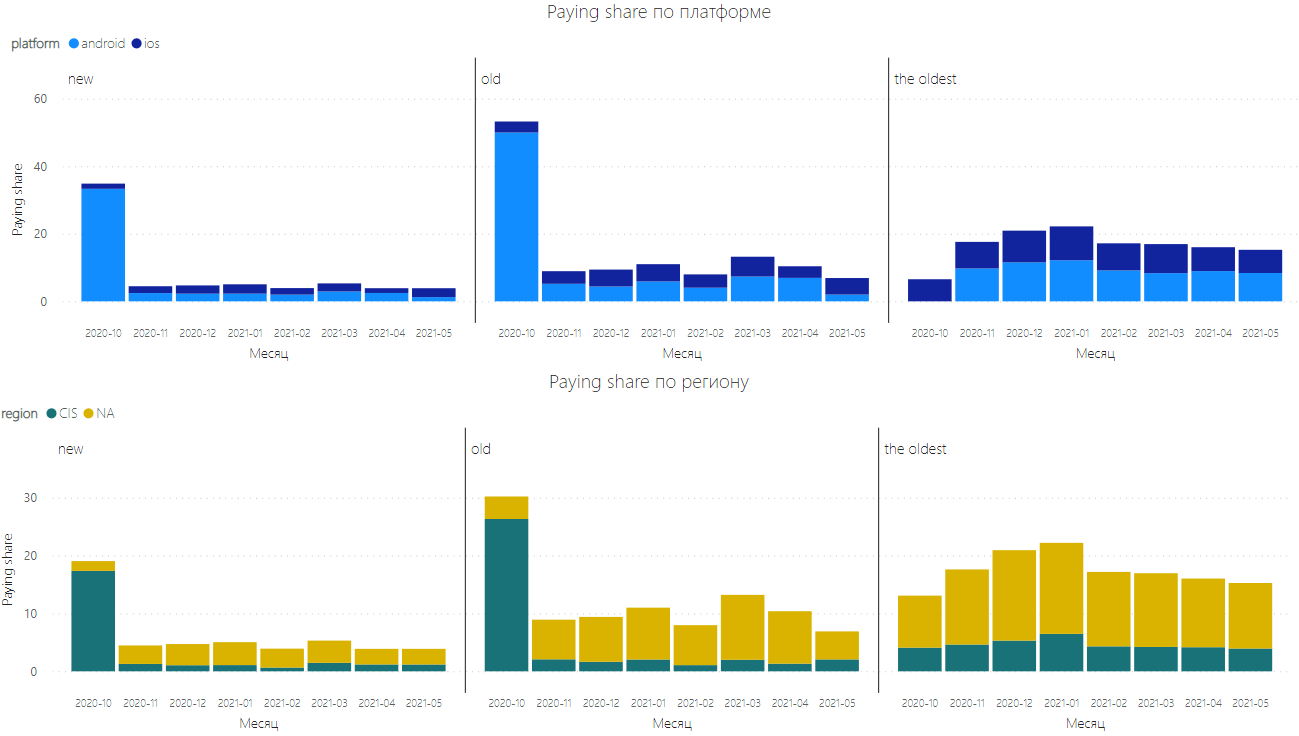 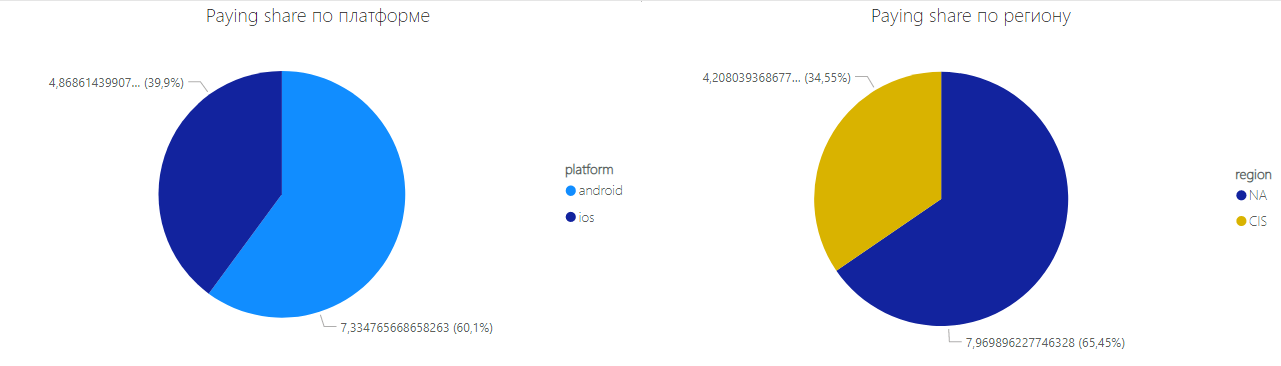

Сравнить процент платящих в каждой из исследуемых когорт, сделать выводы.
    
    Согласно графику выше процент платящих в каждой из когорт выше в ячейке "the oldest",т.е. чем больше месяцев пользователь проводит в игре - тем больше вероятность, что он заплатит. Единственный месяц который отличается - 10-2020 (рассматривается как текущий), но это лишь потому, что это первый месяц в выгрузке и данных об игроках в этом месяце мало - лучше не смотреть на него. Говоря о платформе, то преобладает чаще всего android (с разницей в 20% в среднем). В СНГ конверсия в платящего выше, чем в Северной Америке на 30% в среднем, но где-то и на все 80%. Среднее значение по проценту платящих  по платформе 5-7%, по региону значение выше - около 10% в СНГ и около 5 в Северной Америке.


Ответить на вопрос: «‎Почему у более старых игроков процент платящих отличается от более новых?».

    Чем больше пользователь находится в игре - тем больше игра становится частью его жизни, тем больше хочется пробовать чего-то новое и совершение платежа, тем самым приобретение элементов для повышения комфорта игры, помогает достигать целей и открывать новые возможности. Также, новые пользователи не обладают увереностью того, что игра стоит того, чтобы в нее вложиться.